# BASICS 02 - HOTS algorithm (Lagorce et al. 2017)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os
from timesurface import timesurface
from network import network
from utils import get_loader

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
loader = get_loader(trainset, shuffle=True)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-05-11'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

device -> cuda


## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold, record = True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:47<00:00,  3.49s/it]


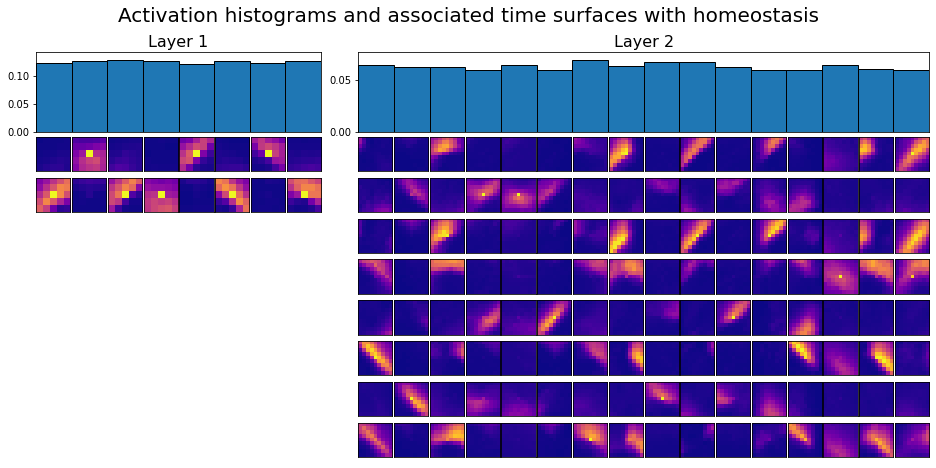

In [6]:
hots.plotlayers();

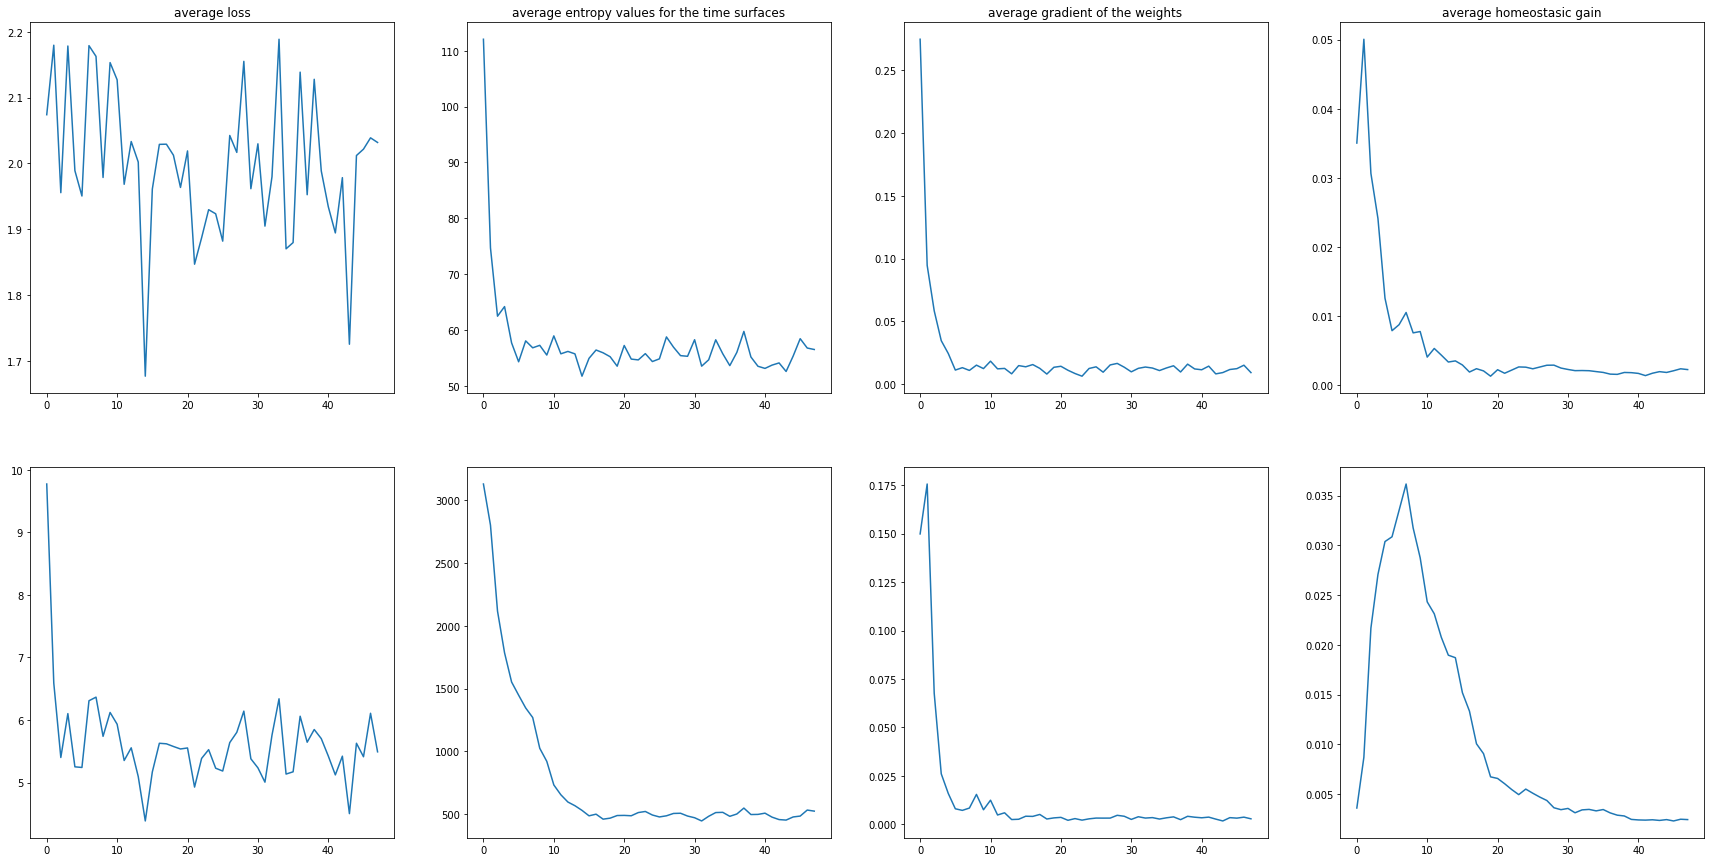

In [7]:
hots.plotlearning();

## Coding of the training set

In [8]:
loader = get_loader(trainset)
num_sample_train = len(loader)
hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:32<00:00,  1.50it/s]


## Coding of the testing set

In [9]:
loader = get_loader(testset)
num_sample_test = len(loader)
hots.coding(loader, testset.ordering, testset.classes, filtering_threshold, training=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


## Classification with histogram (post-hoc)

In [10]:
from utils import make_histogram_classification, HOTS_Dataset

jitter = (None, None)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, trainset.sensor_size, transform=transform, dtype=trainset.dtype)
trainset = HOTS_Dataset(train_path, trainset.sensor_size, transform=transform, dtype=trainset.dtype)

In [11]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1])
print(f' Accuracy: {score*100}%')

 Accuracy: 100.0%
